In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import numpy as np
import pickle

# Measuring mean and variance for times in Local DNS

In [2]:
dns_times = []
hops = []
time = 0
count = 0
with open('../../data/dns_resolution_time_hops.txt', 'r') as file,\
    open('../../data/dns_hops_time.txt', 'w') as out_file:
    for line in file.readlines():
        if '@' in line:
            if time > 0 and time < 600:
                out_file.write(str(time)+' '+str(count)+'\n')
                dns_times.append(time)
                hops.append(count)
            time = 0
            count = 0
        else:
            count += 1
            try:
                time += int(line.split(' ')[-2])
            except ValueError as e:
                time = 0
                count = 0
    out_file.write(str(time)+' '+str(count)+'\n')
    dns_times.append(time)
    hops.append(count)

## Dns resolution times statistics:

Mean: 147.17 ms	Var: 104.84 ms	Median: 124.00 ms
Max: 595.00 ms	Min: 1.00 ms


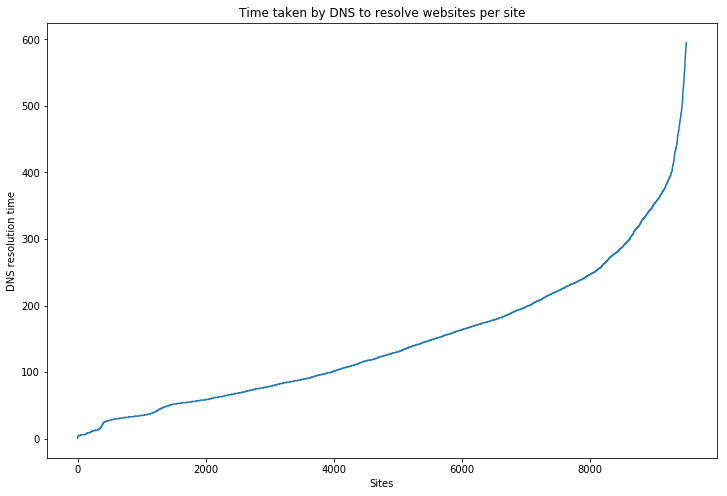

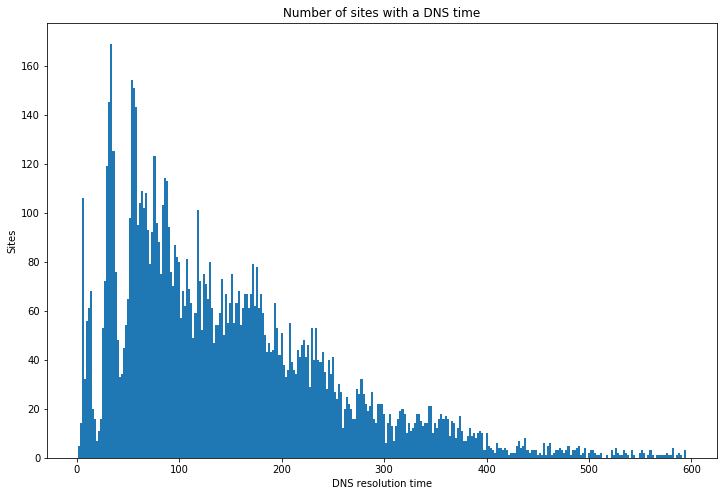

In [33]:
dns_times, hops = zip(*sorted(zip(dns_times, hops)))
mean = np.mean(dns_times)
std = np.std(dns_times)
print('Mean: %.2f ms\tVar: %.2f ms\tMedian: %.2f ms' % (mean, std, dns_times[len(dns_times)//2]))
print('Max: %.2f ms\tMin: %.2f ms' % (max(dns_times), min(dns_times)))

plt.figure(figsize=(12,8))
plt.plot(dns_times)
plt.title('Time taken by DNS to resolve websites per site')
plt.xlabel('Sites')
plt.ylabel('DNS resolution time')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(dns_times, int(max(dns_times))//2)
plt.title('Number of sites with a DNS time')
plt.ylabel('Sites')
plt.xlabel('DNS resolution time')
plt.show()

## Number of hops statistics:

Number of hops statistics:
Mean: 3.86	Var: 0.54	Median: 4.00
Max: 5.00	Min: 1.00


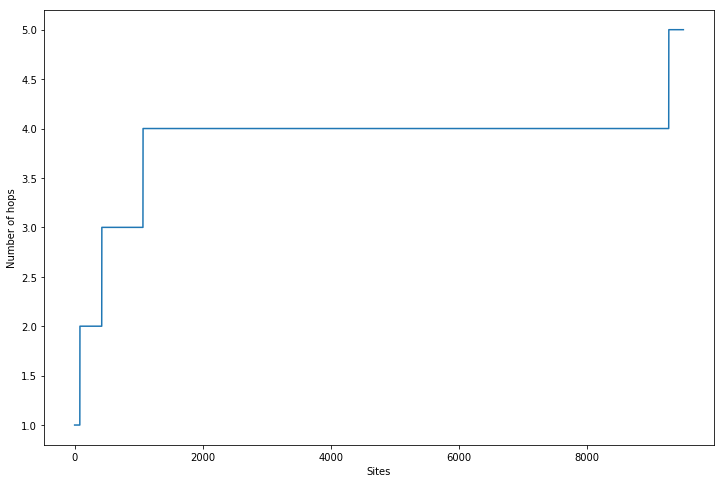

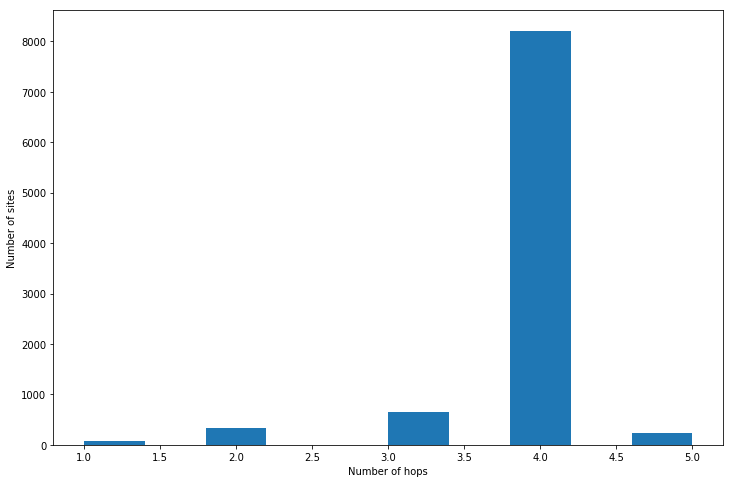

In [34]:
print('Number of hops statistics:')
mean_hops = np.mean(hops)
std_hops = np.std(hops)
print('Mean: %.2f\tVar: %.2f\tMedian: %.2f' % (mean_hops, std_hops, hops[len(hops)//2]))
print('Max: %.2f\tMin: %.2f' % (max(hops), min(hops)))

plt.figure(figsize=(12,8))
plt.plot(sorted(hops))
plt.xlabel('Sites')
plt.ylabel('Number of hops')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(hops)

plt.xlabel('Number of hops')
plt.ylabel('Number of sites')
plt.show()

# Using kernel density

Generating a distribution similar to the above seen distribution based on the assumption that it takes this much time to get a dns record from over a network randomly.

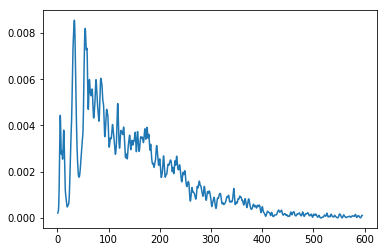

In [38]:
# arr, _, _ = plt.hist(X, int(max(dns_times))//2, normed=True)
X_plot = np.linspace(min(dns_times), max(dns_times), len(dns_times))[:, np.newaxis]
X = np.array(dns_times)[:, np.newaxis]
# for kernel in ['epanechnikov', 'tophat', 'gaussian']:
kernel = 'gaussian'
kde = KernelDensity(kernel=kernel, bandwidth=1).fit(X)
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens), '-',
        label="kernel = '{0}'".format(kernel))
plt.show()

with open(r"kernel_density_model.pickle", "wb") as output_file:
    pickle.dump(kde, output_file)

# Usage docs:

Import the following packages:
```python
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import numpy as np
import pickle
```

Use the following to load the pickle object and generate samples:
```python
with open(r"kernel_density_model.pickle", "rb") as input_file:
     kde = pickle.load(input_file)
```

and to generate samples:
```python
n = 1
time = kde.sample(n) #the time is in milliseconds
time.sleep(time[0]/1000)
```



# Verification of the estimator

Verifying whether the estimator works correctly by generating randomly 1000 samples

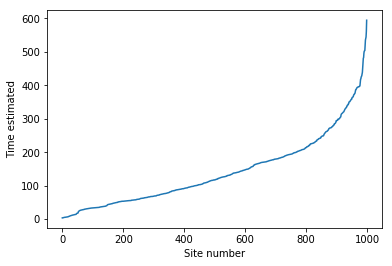

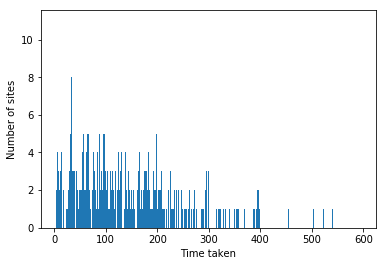

In [14]:
with open(r"kernel_density_model.pickle", "rb") as input_file:
     kde_loaded = pickle.load(input_file)

sample_arr = kde_loaded.sample(1000)
plt.figure()
plt.plot(sorted(sample_arr))
plt.xlabel('Site number')
plt.ylabel('Time estimated')
plt.figure()
plt.hist(sample_arr, 1000)
plt.xlabel('Time taken')
plt.ylabel('Number of sites')
plt.show()

---
# CHORD Implementation and analysis

### Sort the URL's based on their TLD and first Auth Server

Sort it and count number of occurrences. This plot follows a zipf distribution

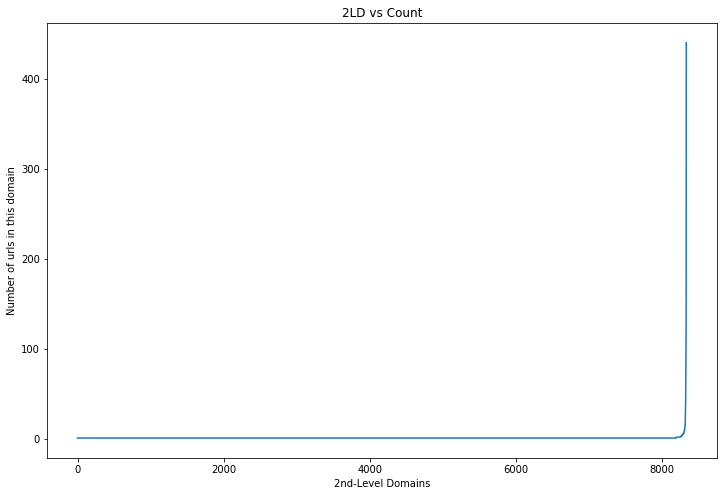

In [37]:
url_list = []
with open('../../data/url_list.txt', 'r') as file:
    for line in file.readlines():
        url_list.append(line.strip())

url_list.sort(key=lambda url:url.split('.')[-2])
url_list.sort(key=lambda url:url.split('.')[-1])

tld_vs_count = dict()
for url in url_list:
    tld = '.'.join(url.split('.')[-2:])
    try: 
        tld_vs_count[tld] +=1 
    except: 
        tld_vs_count[tld] = 1
count_vs_tld = sorted(((v,k) for k,v in tld_vs_count.items()))
plt.figure(figsize=(12,8))
plt.plot([v for v,k in count_vs_tld])
plt.title('2LD vs Count')
plt.xlabel('2nd-Level Domains')
plt.ylabel('Number of urls in this domain')
plt.show()

In [39]:
print(max(tld_vs_count.values()))

440


## Node load, number of nodes serving per 2LD and DNS resolution times

Analysing the load at each node and time taken to resolve each site.

In [9]:
node_load_count = dict()
node_2ld_hops = dict()
chord_times = []
chord_hops = []
with open('../../test_large_final', 'r') as file:
    for line in file.readlines():
        line = line[:-3].split('CRITICAL:')[-1].strip()
        line, hops_list = (line.split(" ['"))
        hops_list = hops_list.split("', '")
        line = line.strip().split(',')
        url = line[0]
        latency = int(line[1])
        proc_time = int(line[2])
        chord_times.append(latency/2+proc_time)
        num_hops = int(line[3])
        chord_hops.append(num_hops)
        name_2ld = '.'.join(url.split('.')[-2:])
        try:
            node_2ld_hops[name_2ld].add(hops_list[-1])
        except KeyError:
            node_2ld_hops[name_2ld] = set({hops_list[-1]})
        for hop in hops_list:
            try:
                node_load_count[hop]+=1
            except KeyError:
                node_load_count[hop]=1
#         break


node_2ld_count = [(k, len(v), tld_vs_count[k], tld_vs_count[k]/len(v)) for k,v in node_2ld_hops.items()]
node_2ld_count.sort(key=lambda k: k[1])
load_count = sorted(node_load_count.values())

Mean: 239.09 ms	Var: 77.17 ms	Median: 232.00 ms
Max: 627.00 ms	Min: 34.50 ms


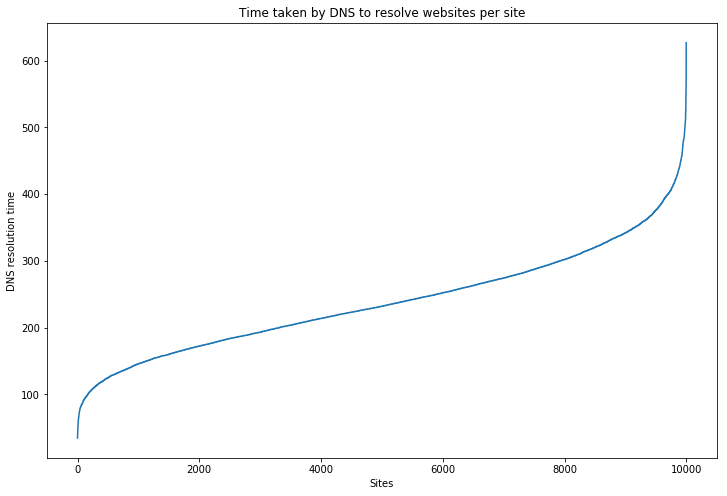

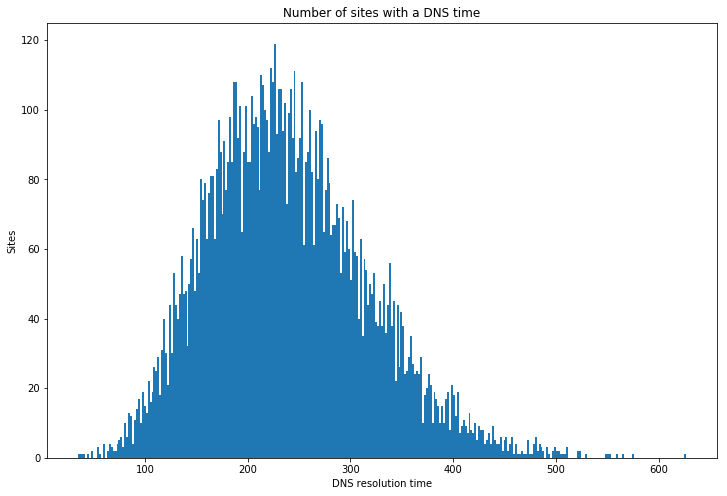

In [32]:
chord_times, chord_hops = zip(*sorted(zip(chord_times, chord_hops)))
mean = np.mean(chord_times)
std = np.std(chord_times)
print('Mean: %.2f ms\tVar: %.2f ms\tMedian: %.2f ms' % (mean, std, chord_times[len(chord_times)//2]))
print('Max: %.2f ms\tMin: %.2f ms' % (max(chord_times), min(chord_times)))

plt.figure(figsize=(12,8))
plt.plot(sorted(chord_times))
plt.title('Time taken by DNS to resolve websites per site')
plt.xlabel('Sites')
plt.ylabel('DNS resolution time')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(chord_times, int(max(chord_times))//2)
plt.title('Number of sites with a DNS time')
plt.ylabel('Sites')
plt.xlabel('DNS resolution time')
plt.show()

Number of hops statistics:
Mean: 4.30	Var: 1.04	Median: 4.00
Max: 7.00	Min: 2.00


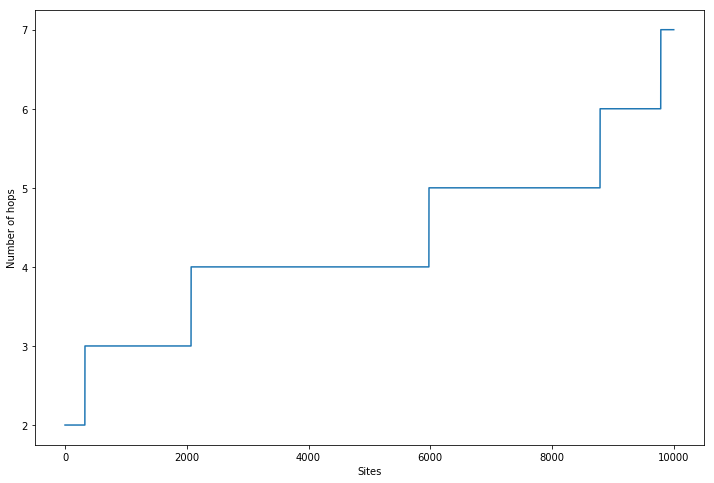

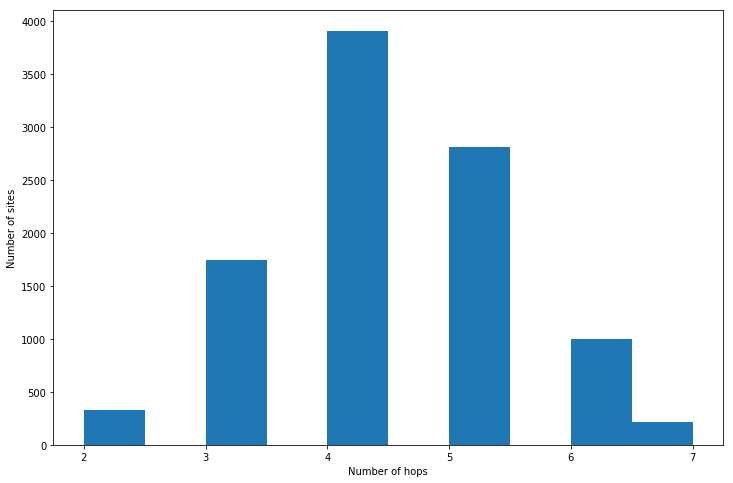

In [31]:
print('Number of hops statistics:')
mean_hops = np.mean(chord_hops)
std_hops = np.std(chord_hops)
print('Mean: %.2f\tVar: %.2f\tMedian: %.2f' % (mean_hops, std_hops, chord_hops[len(chord_hops)//2]))
print('Max: %.2f\tMin: %.2f' % (max(chord_hops), min(chord_hops)))

plt.figure(figsize=(12,8))
plt.plot(sorted(chord_hops))
plt.xlabel('Sites')
plt.ylabel('Number of hops')
plt.show()

plt.figure(figsize=(12,8))
plt.hist(chord_hops)
plt.xlabel('Number of hops')
plt.ylabel('Number of sites')
plt.show()

### 2ld domain distribution statistics

2ld domain distribution statistics:
Mean: 1.07	Var: 0.86	Median: 1.00
Max: 29.00	Min: 1.00


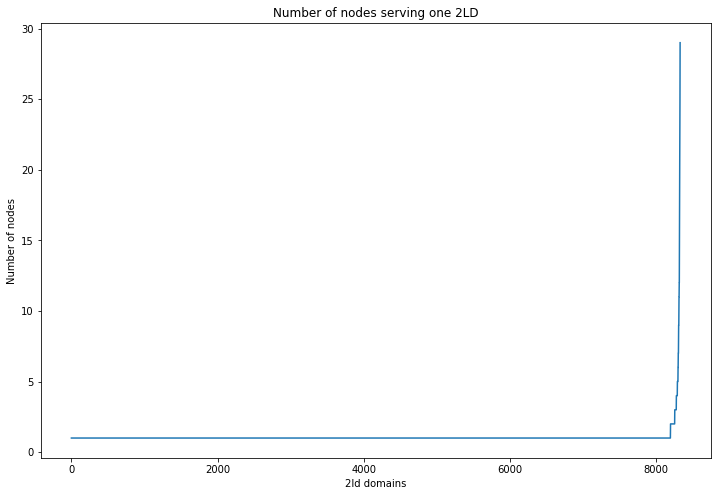

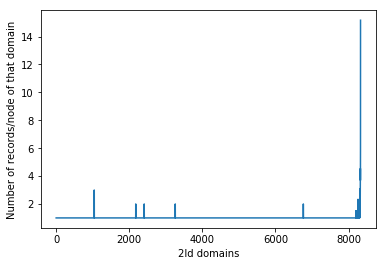

In [41]:
print('2ld domain distribution statistics:')
site_count = [v for _,v,_,_ in node_2ld_count]
mean_nodes = np.mean(site_count)
std_nodes = np.std(site_count)
print('Mean: %.2f\tVar: %.2f\tMedian: %.2f' % (mean_nodes, std_nodes, site_count[len(site_count)//2]))
print('Max: %.2f\tMin: %.2f' % (max(site_count), min(site_count)))
plt.figure(figsize=(12,8))
plt.plot(site_count)
plt.title('Number of nodes serving one 2LD')
plt.xlabel('2ld domains')
plt.ylabel('Number of nodes')

plt.figure(figsize=(12,8))
plt.figure()
plt.plot([v for _,_,_,v in node_2ld_count])
plt.xlabel('2ld domains')
plt.ylabel('Number of records/node of that domain')
plt.show()

### Node load statistics

Number of hops statistics:
Mean: 1434.97	Var: 959.20	Median: 1250.00
Max: 4759.00	Min: 495.00


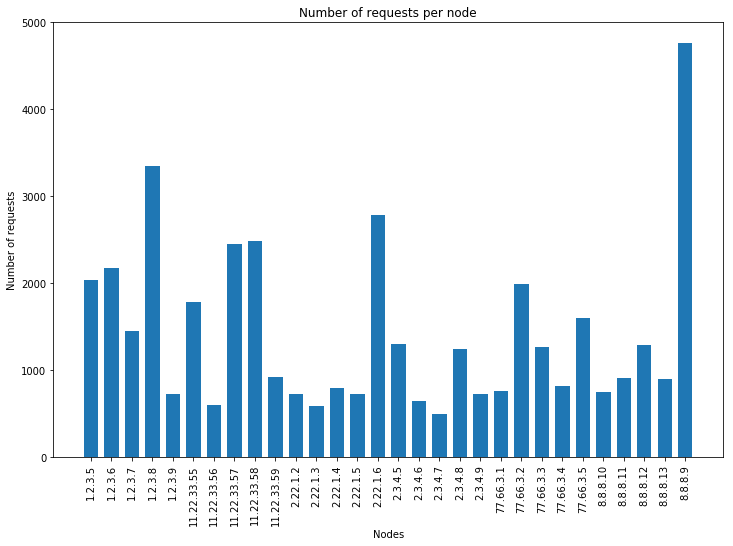

In [27]:
print('Number of hops statistics:')
keys = sorted(node_load_count.keys())
values = [node_load_count[k] for k in keys]
mean_nodes = np.mean(values)
std_nodes = np.std(values)
print('Mean: %.2f\tVar: %.2f\tMedian: %.2f' % (mean_nodes, std_nodes, load_count[len(load_count)//2]))
print('Max: %.2f\tMin: %.2f' % (max(load_count), min(load_count)))
plt.figure(figsize=(12,8))
plt.bar(range(len(keys)), values, align='center', width=0.7)
plt.xticks(range(len(keys)), keys, rotation='vertical')
plt.title('Number of requests per node')
plt.xlabel('Nodes')
plt.ylabel('Number of requests')
plt.show()

## Comparision

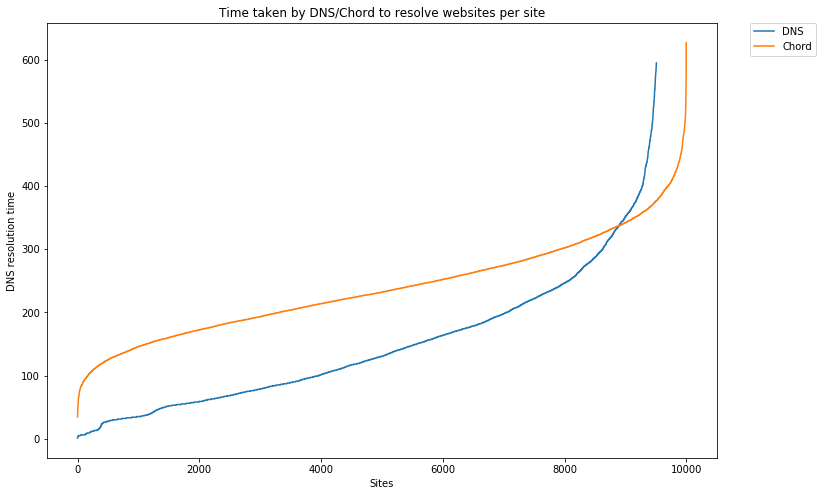

In [28]:

plt.figure(figsize=(12,8))
plt.plot(dns_times, label='DNS')
plt.plot(chord_times, label='Chord')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Time taken by DNS/Chord to resolve websites per site')
plt.xlabel('Sites')
plt.ylabel('DNS resolution time')
plt.show()

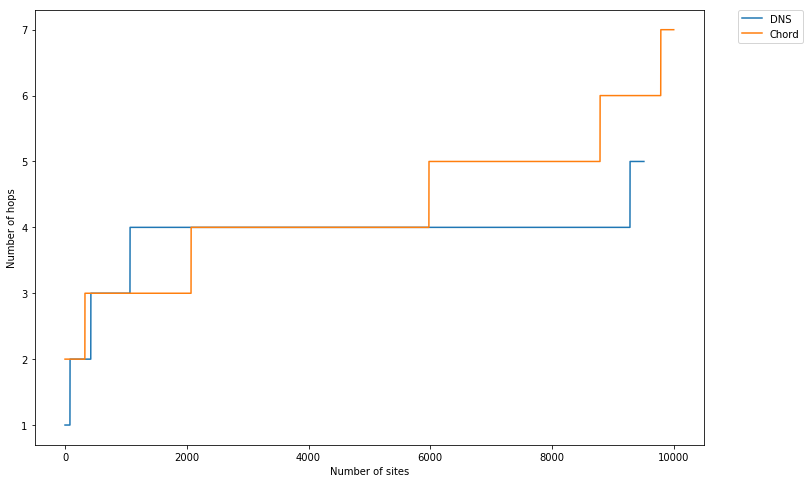

In [40]:
plt.figure(figsize=(12,8))
plt.plot(sorted(hops), label='DNS')
plt.plot(sorted(chord_hops), label='Chord')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Number of hops')
plt.xlabel('Number of sites')
plt.show()